# 09 Demo: Multidimensional (N-d) arrays, xarray, ERA5 climate reanalysis data

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## Introduction

This week we are going to do some basic analysis of climate reanalysis data. This could be useful for some of your projects, especially if considering time series data.

We will use a few different products from the state-of-the-art global ERA5 reanalysis, which currently span 1950-present with hourly timestep at up to a 9 km resolution.

We will use xarray to open, combine, analyze and plot the data.

## xarray

Take a moment to review this high-level introduction:
* http://xarray.pydata.org/en/stable/why-xarray.html

>"xarray (formerly xray) is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!

>Xarray introduces **labels** in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures.

>Xarray is inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with dask for parallel computing."

Remember back to Lab03, when you tried to extract a column of elevation values from a 2D NumPy array, with something like `myarray[:,4]`?  And then how much easier it was to do the same thing with a labeled pandas DataFrame `mydf['glas_z']`? Same deal here, just extended beyond 2D.

Why?
* Excellent choice for working with large datasets, as it uses lazy evaluation and parallel processing with Dask: http://xarray.pydata.org/en/stable/dask.html#
* Lots of great tutorials and resources: https://xarray.pydata.org/en/stable/tutorials-and-videos.html
* Big user community
* Some feel it should be the defacto Python data science object: https://xarray.pydata.org/en/stable/getting-started-guide/why-xarray.html#goals-and-aspirations

Why not?
* General means complicated
* Steep learning curve, esp for new users unfamiliar with Pandas
* Sometimes overkill for simple problems

## xarray data model overview
So, what's an nD array? (https://numpy.org/doc/stable/reference/arrays.ndarray.html). You've been using them all quarter, but mostly 1D and 2D NumPy arrays.  

As with many of the packages we've covered this quarter, vocabulary can be one of the biggest blocks to learning.  Let's discuss.

![xarray image with labels](http://matthewrocklin.com/blog/images/xarray-boxes-2.png)
(http://xarray.pydata.org/en/latest/data-structures.html#dataset)

### Comparison with Pandas

Pandas is very good at handling 2D tabular datasets (e.g., csv with columns and rows, time series of met station variables from a single station [T, precip, etc]) or a single variable across multiple stations.  
* "If your data fits nicely into a pandas DataFrame then you’re better off using one of the more developed tools there." (https://xarray.pydata.org/en/latest/user-guide/plotting.html)
* https://xarray.pydata.org/en/stable/getting-started-guide/faq.html#should-i-use-xarray-instead-of-pandas
* "pandas excels at working with tabular data. That suffices for many statistical analyses, but physical scientists rely on N-dimensional arrays – which is where xarray comes in." (http://xarray.pydata.org/en/stable/why-xarray.html#goals-and-aspirations)

xarray extends the Pandas functionality to support 3+ dimensions (e.g., time series of 2D rasters).

#### xarray is to Pandas...

* xarray DataArray : Pandas DataSeries
* xarray DataSet : Pandas DataFrame

## Terminology
* https://xarray.pydata.org/en/stable/user-guide/terminology.html
* https://xarray.pydata.org/en/latest/user-guide/data-structures.html#data-structures

### DataArray
Four essential pieces:
* `values`: a numpy.ndarrays with actual data values (e.g., ('2-m air temperature (t2m)', 'Total precipitation (tp)')
* `dims`: dimension names for each axis (e.g., ('lon', 'lat', 'time'))
* `coords`: a dict-like container of arrays that label each value in each dimension (e.g., 1-D array of x coordinates, 1-D array of y coordiantes, datetime objects or strings)
* `attrs`: an OrderedDict containing additional metadata (attributes)

#### Why do we need both `dims` and `coords`?
>"Dimensions provide names that xarray uses instead of the axis argument found in many numpy functions. Coordinates enable fast label based indexing and alignment, building on the functionality of the index found on a pandas DataFrame or Series."

### Dataset
* Essentially, a collection of DataArrays (like a dictionary of DataArrays)
* http://xarray.pydata.org/en/latest/data-structures.html#dataset

Notes:
* One value in one of the contained arrays (say a single temperature measurement) usually has multiple coordinates ('lon', 'lat', 'time')

### Useful xarray examples and references
* Indexing and selection: https://xarray.pydata.org/en/stable/user-guide/indexing.html
* Plotting: https://xarray.pydata.org/en/stable/user-guide/plotting.html
* Visualization examples: http://xarray.pydata.org/en/stable/examples/visualization_gallery.html
* Time-series analysis: https://xarray.pydata.org/en/stable/user-guide/time-series.html
* https://rabernat.github.io/research_computing/xarray.html

## netCDF format
Much of the xarray design and functionality is derived from the NetCDF project:

>"NetCDF (Network Common Data Form) is a set of software libraries and machine-independent data formats that support the creation, access, and sharing of array-oriented scientific data. It is also a community standard for sharing scientific data." https://www.unidata.ucar.edu/software/netcdf/

>"Data in netCDF format is:
>* Self-Describing. A netCDF file includes information about the data it contains.
>* Portable. A netCDF file can be accessed by computers with different ways of storing integers, characters, and floating-point numbers.
>* Scalable. Small subsets of large datasets in various formats may be accessed efficiently through netCDF interfaces, even from remote servers.
>* Appendable. Data may be appended to a properly structured netCDF file without copying the dataset or redefining its structure.
>* Sharable. One writer and multiple readers may simultaneously access the same netCDF file.
>* Archivable. Access to all earlier forms of netCDF data will be supported by current and future versions of the software."


>"Commonly used in climatology, meteorology and oceanography applications (e.g., weather forecasting, climate change) and GIS applications." https://en.wikipedia.org/wiki/NetCDF

In [ ]:
import xarray as xr
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Demo: Create simple DataArray
* From https://xarray.pydata.org/en/latest/user-guide/data-structures.html#data-structures

In [ ]:
from numpy.random import RandomState
prng = RandomState(1234567890)

In [ ]:
#data = np.random.rand(4, 3)
#Use fixed instance of random state to reduce diff as notebook is modified in future years
data = prng.rand(4, 3)
data

array([[0.61879477, 0.59162363, 0.88868359],
       [0.8916548 , 0.45756748, 0.77818808],
       [0.26706377, 0.99610621, 0.54009489],
       [0.53752161, 0.40099938, 0.70540579]])

In [ ]:
#xr.DataArray?

In [ ]:
xr.DataArray(data)

<xarray.DataArray (dim_0: 4, dim_1: 3)>
array([[0.61879477, 0.59162363, 0.88868359],
       [0.8916548 , 0.45756748, 0.77818808],
       [0.26706377, 0.99610621, 0.54009489],
       [0.53752161, 0.40099938, 0.70540579]])
Dimensions without coordinates: dim_0, dim_1

In [ ]:
locs = ["WA", "OR", "CA"]

In [ ]:
times = pd.date_range("2000-01-01", periods=4)
times

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04'], dtype='datetime64[ns]', freq='D')

In [ ]:
foo = xr.DataArray(data, coords=[times, locs], dims=["time", "space"])

In [ ]:
foo

<xarray.DataArray (time: 4, space: 3)>
array([[0.61879477, 0.59162363, 0.88868359],
       [0.8916548 , 0.45756748, 0.77818808],
       [0.26706377, 0.99610621, 0.54009489],
       [0.53752161, 0.40099938, 0.70540579]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'WA' 'OR' 'CA'

### Indexing
* https://docs.xarray.dev/en/stable/user-guide/indexing.html

In [ ]:
foo.values

array([[0.61879477, 0.59162363, 0.88868359],
       [0.8916548 , 0.45756748, 0.77818808],
       [0.26706377, 0.99610621, 0.54009489],
       [0.53752161, 0.40099938, 0.70540579]])

In [ ]:
foo.shape

(4, 3)

In [ ]:
foo[0,0]

<xarray.DataArray ()>
array(0.61879477)
Coordinates:
    time     datetime64[ns] 2000-01-01
    space    <U2 'WA'

In [ ]:
foo[0, :]

<xarray.DataArray (space: 3)>
array([0.61879477, 0.59162363, 0.88868359])
Coordinates:
    time     datetime64[ns] 2000-01-01
  * space    (space) <U2 'WA' 'OR' 'CA'

In [ ]:
foo.loc['2000-01-03']

<xarray.DataArray (space: 3)>
array([0.26706377, 0.99610621, 0.54009489])
Coordinates:
    time     datetime64[ns] 2000-01-03
  * space    (space) <U2 'WA' 'OR' 'CA'

In [ ]:
foo.loc[:,'WA']

<xarray.DataArray (time: 4)>
array([0.61879477, 0.8916548 , 0.26706377, 0.53752161])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
    space    <U2 'WA'

In [ ]:
#This doesn't work
#foo.loc['WA', '2000-01-03']
#Axis order matters!
#foo.loc['2000-01-03', 'WA']

In [ ]:
foo.sel(time='2000-01-03', space='WA')

<xarray.DataArray ()>
array(0.26706377)
Coordinates:
    time     datetime64[ns] 2000-01-03
    space    <U2 'WA'

In [ ]:
foo.sel(space='WA', time='2000-01-03')

<xarray.DataArray ()>
array(0.26706377)
Coordinates:
    time     datetime64[ns] 2000-01-03
    space    <U2 'WA'

In [ ]:
foo.sel(space=['WA','OR'], time='2000-01-03')

<xarray.DataArray (space: 2)>
array([0.26706377, 0.99610621])
Coordinates:
    time     datetime64[ns] 2000-01-03
  * space    (space) <U2 'WA' 'OR'

In [ ]:
#No iloc, but can select based on integer index
foo.isel(time=3, space=1)

<xarray.DataArray ()>
array(0.40099938)
Coordinates:
    time     datetime64[ns] 2000-01-04
    space    <U2 'OR'

## Demo: Create xarray DataSet from SNOTEL data

In [ ]:
snotel_datadir = '../08_Vector_TimeSeries_SNOTEL/snotel_data'

In [ ]:
#SNOTEL sites (with lat/lon coordiantes) for CONUS
sites_fn = os.path.join(snotel_datadir, 'snotel_conus_sites.json')
#singlesite_pkl_fn = 'SNOTEL-SNWD_D_679_WA_SNTL.pkl'
#Snow depth DataFrame for CONUS sites
allsites_SNWD_pkl_fn = os.path.join(snotel_datadir, 'SNOTEL-SNWD_D_CONUS_all.pkl')
#Snow water equivalent DataFrame for WA
allsites_WTEQ_pkl_fn = os.path.join(snotel_datadir, 'SNOTEL-WTEQ_D_WA.pkl')

In [ ]:
sites_gdf_all = gpd.read_file(sites_fn).set_index('index')
allsites_snwd_df = pd.read_pickle(allsites_SNWD_pkl_fn).dropna(axis=0, how='all')
allsites_wteq_df = pd.read_pickle(allsites_WTEQ_pkl_fn).dropna(axis=0, how='all')

In [ ]:
sites_gdf_all.head()

code             name network  elevation_m  \
index                                                                   
SNOTEL:301_CA_SNTL  301_CA_SNTL         Adin Mtn  SNOTEL  1886.712036   
SNOTEL:907_UT_SNTL  907_UT_SNTL      Agua Canyon  SNOTEL  2712.719971   
SNOTEL:916_MT_SNTL  916_MT_SNTL       Albro Lake  SNOTEL  2529.840088   
SNOTEL:908_WA_SNTL  908_WA_SNTL   Alpine Meadows  SNOTEL  1066.800049   
SNOTEL:302_OR_SNTL  302_OR_SNTL  Aneroid Lake #2  SNOTEL  2255.520020   

                     county       state pos_accuracy_m              beginDate  \
index                                                                           
SNOTEL:301_CA_SNTL    Modoc  California              0  10/1/1983 12:00:00 AM   
SNOTEL:907_UT_SNTL     Kane        Utah              0  10/1/1994 12:00:00 AM   
SNOTEL:916_MT_SNTL  Madison     Montana              0   9/1/1996 12:00:00 AM   
SNOTEL:908_WA_SNTL     King  Washington              0   9/1/1994 12:00:00 AM   
SNOTEL:302_OR_SNTL  Wallowa      Oregon              0  10/1/1980 12:00:00 AM   

                                 endDate           HUC       HUD TimeZone  \
index                                                                       
SNOTEL:301_CA_SNTL  1/1/2100 12:00:00 AM  180200021403  18020002     -8.0   
SNOTEL:907_UT_SNTL  1/1/2100 12:00:00 AM  160300020301  16030002     -8.0   
SNOTEL:916_MT_SNTL  1/1/2100 12:00:00 AM  100200050701  10020005     -8.0   
SNOTEL:908_WA_SNTL  1/1/2100 12:00:00 AM  171100100501  17110010     -8.0   
SNOTEL:302_OR_SNTL  1/1/2100 12:00:00 AM  170601050101  17060105     -8.0   

                   actonId shefId stationTriplet isActive HUC2    HUC6  \
index                                                                    
SNOTEL:301_CA_SNTL  20H13S  ADMC1    301:CA:SNTL     True   18  180200   
SNOTEL:907_UT_SNTL  12M26S  AGUU1    907:UT:SNTL     True   16  160300   
SNOTEL:916_MT_SNTL  11D28S  ABRM8    916:MT:SNTL     True   10  100200   
SNOTEL:908_WA_SNTL  21B48S  APSW1    908:WA:SNTL     True   17  171100   
SNOTEL:302_OR_SNTL  17D02S  ANRO3    302:OR:SNTL     True   17  170601   

                                       geometry  
index                                            
SNOTEL:301_CA_SNTL  POINT (-120.79192 41.23583)  
SNOTEL:907_UT_SNTL  POINT (-112.27118 37.52217)  
SNOTEL:916_MT_SNTL  POINT (-111.95902 45.59723)  
SNOTEL:908_WA_SNTL  POINT (-121.69847 47.77957)  
SNOTEL:302_OR_SNTL  POINT (-117.19258 45.21328)

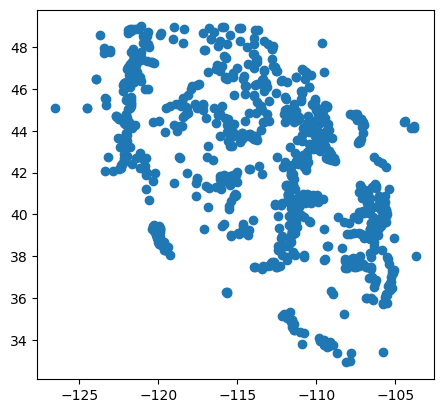

In [ ]:
sites_gdf_all.plot();

In [ ]:
allsites_snwd_df.tail()

SNOTEL:301_CA_SNTL  SNOTEL:907_UT_SNTL  \
datetime                                                            
2023-02-19 00:00:00+00:00                42.0                33.0   
2023-02-20 00:00:00+00:00                41.0                32.0   
2023-02-21 00:00:00+00:00                40.0                31.0   
2023-02-22 00:00:00+00:00                40.0                32.0   
2023-02-23 00:00:00+00:00                44.0                38.0   

                           SNOTEL:916_MT_SNTL  SNOTEL:908_WA_SNTL  \
datetime                                                            
2023-02-19 00:00:00+00:00                48.0                78.0   
2023-02-20 00:00:00+00:00                47.0                84.0   
2023-02-21 00:00:00+00:00                46.0                86.0   
2023-02-22 00:00:00+00:00                53.0                 NaN   
2023-02-23 00:00:00+00:00                52.0                91.0   

                           SNOTEL:302_OR_SNTL  SNOTEL:1000_OR_SNTL  \
datetime                                                             
2023-02-19 00:00:00+00:00                55.0                 76.0   
2023-02-20 00:00:00+00:00                56.0                 75.0   
2023-02-21 00:00:00+00:00                55.0                 73.0   
2023-02-22 00:00:00+00:00                56.0                 83.0   
2023-02-23 00:00:00+00:00                56.0                 90.0   

                           SNOTEL:303_CO_SNTL  SNOTEL:1030_CO_SNTL  \
datetime                                                             
2023-02-19 00:00:00+00:00                 8.0                 60.0   
2023-02-20 00:00:00+00:00                 8.0                 62.0   
2023-02-21 00:00:00+00:00                10.0                 61.0   
2023-02-22 00:00:00+00:00                 6.0                  NaN   
2023-02-23 00:00:00+00:00                 8.0                 67.0   

                           SNOTEL:304_OR_SNTL  SNOTEL:306_ID_SNTL  ...  \
datetime                                                           ...   
2023-02-19 00:00:00+00:00                44.0                68.0  ...   
2023-02-20 00:00:00+00:00                44.0                70.0  ...   
2023-02-21 00:00:00+00:00                43.0                71.0  ...   
2023-02-22 00:00:00+00:00                51.0                76.0  ...   
2023-02-23 00:00:00+00:00                52.0                78.0  ...   

                           SNOTEL:872_WY_SNTL  SNOTEL:873_OR_SNTL  \
datetime                                                            
2023-02-19 00:00:00+00:00                27.0                48.0   
2023-02-20 00:00:00+00:00                28.0                49.0   
2023-02-21 00:00:00+00:00                29.0                48.0   
2023-02-22 00:00:00+00:00                39.0                52.0   
2023-02-23 00:00:00+00:00                 NaN                57.0   

                           SNOTEL:874_CO_SNTL  SNOTEL:875_WY_SNTL  \
datetime                                                            
2023-02-19 00:00:00+00:00                88.0                29.0   
2023-02-20 00:00:00+00:00                88.0                33.0   
2023-02-21 00:00:00+00:00                86.0                42.0   
2023-02-22 00:00:00+00:00                86.0                45.0   
2023-02-23 00:00:00+00:00                98.0                44.0   

                           SNOTEL:876_MT_SNTL  SNOTEL:877_AZ_SNTL  \
datetime                                                            
2023-02-19 00:00:00+00:00                25.0                26.0   
2023-02-20 00:00:00+00:00                26.0                24.0   
2023-02-21 00:00:00+00:00                33.0                21.0   
2023-02-22 00:00:00+00:00                35.0                19.0   
2023-02-23 00:00:00+00:00                33.0                23.0   

                           SNOTEL:1228_UT_SNTL  SNOTEL:1197_UT_SNTL  \
datetime                           

In [ ]:
allsites_wteq_df.tail()

SNOTEL:908_WA_SNTL  SNOTEL:990_WA_SNTL  \
datetime                                                            
2023-02-21 00:00:00+00:00                38.1                24.6   
2023-02-22 00:00:00+00:00                37.7                24.8   
2023-02-23 00:00:00+00:00                37.5                24.6   
2023-02-24 00:00:00+00:00                37.6                24.4   
2023-02-25 00:00:00+00:00                37.8                24.5   

                           SNOTEL:352_WA_SNTL  SNOTEL:1080_WA_SNTL  \
datetime                                                             
2023-02-21 00:00:00+00:00                 9.8                 40.0   
2023-02-22 00:00:00+00:00                10.2                 40.5   
2023-02-23 00:00:00+00:00                10.4                 40.4   
2023-02-24 00:00:00+00:00                10.4                 40.2   
2023-02-25 00:00:00+00:00                10.4                 40.3   

                           SNOTEL:1107_WA_SNTL  SNOTEL:375_WA_SNTL  \
datetime                                                             
2023-02-21 00:00:00+00:00                 33.3                16.4   
2023-02-22 00:00:00+00:00                 34.2                16.7   
2023-02-23 00:00:00+00:00                 34.3                16.7   
2023-02-24 00:00:00+00:00                 34.2                16.7   
2023-02-25 00:00:00+00:00                 34.3                16.7   

                           SNOTEL:376_WA_SNTL  SNOTEL:942_WA_SNTL  \
datetime                                                            
2023-02-21 00:00:00+00:00                16.3                16.6   
2023-02-22 00:00:00+00:00                16.9                16.4   
2023-02-23 00:00:00+00:00                16.9                16.7   
2023-02-24 00:00:00+00:00                16.7                16.3   
2023-02-25 00:00:00+00:00                16.7                16.5   

                           SNOTEL:1109_WA_SNTL  SNOTEL:1085_WA_SNTL  ...  \
datetime                                                             ...   
2023-02-21 00:00:00+00:00                  0.2                 36.9  ...   
2023-02-22 00:00:00+00:00                  1.1                 37.2  ...   
2023-02-23 00:00:00+00:00                  1.5                 37.0  ...   
2023-02-24 00:00:00+00:00                  1.6                 37.0  ...   
2023-02-25 00:00:00+00:00                  1.6                 37.2  ...   

                           SNOTEL:1012_WA_SNTL  SNOTEL:817_WA_SNTL  \
datetime                                                             
2023-02-21 00:00:00+00:00                 61.5                22.2   
2023-02-22 00:00:00+00:00                 62.9                22.2   
2023-02-23 00:00:00+00:00                 63.6                22.2   
2023-02-24 00:00:00+00:00                 63.5                22.0   
2023-02-25 00:00:00+00:00                 63.5                22.1   

                           SNOTEL:899_WA_SNTL  SNOTEL:824_WA_SNTL  \
datetime                                                            
2023-02-21 00:00:00+00:00                22.8                24.1   
2023-02-22 00:00:00+00:00                23.6                24.4   
2023-02-23 00:00:00+00:00                23.5                24.2   
2023-02-24 00:00:00+00:00                23.5                24.1   
2023-02-25 00:00:00+00:00                23.4                24.3   

                           SNOTEL:1171_WA_SNTL  SNOTEL:832_WA_SNTL  \
datetime                                                             
2023-02-21 00:00:00+00:00                 24.2                12.1   
2023-02-22 00:00:00+00:00                 24.3                12.1   
2023-02-23 00:00:00+00:00                 24.2                12.4   
2023-02-24 00:00:00+00:00                 24.1                12.4   
2023-02-25 00:00:00+00:00                 24.1                12.6   

                           SNOTEL:841_WA_SNTL  SNOTEL:974_WA_SNTL  \
datetime 

###  Note difference in number of records and columns
* Some stations have one but not the other
* WTEQ extends farther back in time

### Convert to xarray DataArrays
* Sometimes `to_xarray()` just works
    * https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_xarray.html
* We have a GeoDataFrame with locations, and then two separate DataFrames with timestamps and values

In [ ]:
#Doesn't quite work for our sites
#sites_gdf_all.to_xarray()

In [ ]:
#Doesn't quite work for our time series
#allsites_snwd_df.to_xarray()

In [ ]:
#Function to prepare xarray DataArray for SNOTEL sites and time series
def get_DataArray(df, sites, name="SNWD_D"):
    valid_sites = sites.loc[df.columns]
    
    site_id = valid_sites.index.values
    lon = valid_sites.geometry.x.values
    lat = valid_sites.geometry.y.values
    elev = valid_sites.elevation_m.values
    site_name = valid_sites.name.values
    
    #da = xr.DataArray(df, dims=("time", "site_id"), name=name)
    da = xr.DataArray(df, dims=("time", "site_id"), coords=(df.index.values, site_id), name=name)
    #For some reason, the times are not read as datetime64 objects, so reassign
    da["time"] = df.index.values
    da = da.assign_coords(lon=("site_id", lon), lat=("site_id", lat), elev=("site_id", elev))
    return da

In [ ]:
snwd_da = get_DataArray(allsites_snwd_df, sites_gdf_all, name="SNWD_D")

In [ ]:
snwd_da

<xarray.DataArray 'SNWD_D' (time: 10807, site_id: 806)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [40., 31., 46., ..., 35., 42., 68.],
       [40., 32., 53., ..., 34., 46., 70.],
       [44., 38., 52., ..., 41., 45., 73.]])
Coordinates:
  * time     (time) datetime64[ns] 1984-10-01 1984-10-02 ... 2023-02-23
  * site_id  (site_id) object 'SNOTEL:301_CA_SNTL' ... 'SNOTEL:1033_CO_SNTL'
    lon      (site_id) float64 -120.8 -112.3 -112.0 ... -112.8 -109.8 -106.6
    lat      (site_id) float64 41.24 37.52 45.6 47.78 ... 37.75 43.93 40.79
    elev     (site_id) float64 1.887e+03 2.713e+03 ... 2.545e+03 2.847e+03

#### Add some attributes

In [ ]:
snwd_da.attrs['description'] = 'SNOTEL snow depth measurements (SNWD_D)'
snwd_da.attrs['units'] = 'inches'

In [ ]:
snwd_da

<xarray.DataArray 'SNWD_D' (time: 10807, site_id: 806)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [40., 31., 46., ..., 35., 42., 68.],
       [40., 32., 53., ..., 34., 46., 70.],
       [44., 38., 52., ..., 41., 45., 73.]])
Coordinates:
  * time     (time) datetime64[ns] 1984-10-01 1984-10-02 ... 2023-02-23
  * site_id  (site_id) object 'SNOTEL:301_CA_SNTL' ... 'SNOTEL:1033_CO_SNTL'
    lon      (site_id) float64 -120.8 -112.3 -112.0 ... -112.8 -109.8 -106.6
    lat      (site_id) float64 41.24 37.52 45.6 47.78 ... 37.75 43.93 40.79
    elev     (site_id) float64 1.887e+03 2.713e+03 ... 2.545e+03 2.847e+03
Attributes:
    description:  SNOTEL snow depth measurements (SNWD_D)
    units:        inches

In [ ]:
#Prepare a separate Data Array for the WTEQ_D data
wteq_da = get_DataArray(allsites_wteq_df, sites_gdf_all, name="WTEQ_D")

In [ ]:
wteq_da

<xarray.DataArray 'WTEQ_D' (time: 16219, site_id: 74)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [37.5, 24.6, 10.4, ..., 21. , 25.3, 17.9],
       [37.6, 24.4, 10.4, ..., 20.9, 25.2, 17.8],
       [37.8, 24.5, 10.4, ..., 21. , 25.4, 17.8]])
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:908_WA_SNTL' ... 'SNOTEL:863_WA_SNTL'
    lon      (site_id) float64 -121.7 -121.3 -120.7 ... -123.4 -121.8 -121.4
    lat      (site_id) float64 47.78 48.88 47.35 48.93 ... 47.94 48.87 46.64
    elev     (site_id) float64 1.067e+03 1.106e+03 ... 1.228e+03 1.353e+03

In [ ]:
wteq_da.attrs['description'] = 'SNOTEL snow water equivalent measurements (WTEQ_D)'
wteq_da.attrs['units'] = 'inches w.e.'

In [ ]:
wteq_da

<xarray.DataArray 'WTEQ_D' (time: 16219, site_id: 74)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [37.5, 24.6, 10.4, ..., 21. , 25.3, 17.9],
       [37.6, 24.4, 10.4, ..., 20.9, 25.2, 17.8],
       [37.8, 24.5, 10.4, ..., 21. , 25.4, 17.8]])
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:908_WA_SNTL' ... 'SNOTEL:863_WA_SNTL'
    lon      (site_id) float64 -121.7 -121.3 -120.7 ... -123.4 -121.8 -121.4
    lat      (site_id) float64 47.78 48.88 47.35 48.93 ... 47.94 48.87 46.64
    elev     (site_id) float64 1.067e+03 1.106e+03 ... 1.228e+03 1.353e+03
Attributes:
    description:  SNOTEL snow water equivalent measurements (WTEQ_D)
    units:        inches w.e.

### Merge the two DataArrays into a single DataSet

In [ ]:
ds = xr.merge([snwd_da, wteq_da])

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (time: 16219, site_id: 806)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:1000_OR_SNTL' ... 'SNOTEL:999_WA_SNTL'
    lon      (site_id) float64 -122.2 -105.4 -116.9 ... -110.8 -121.4 -121.7
    lat      (site_id) float64 42.87 37.61 40.36 46.91 ... 40.89 48.86 48.76
    elev     (site_id) float64 1.832e+03 3.246e+03 ... 1.606e+03 1.073e+03
Data variables:
    SNWD_D   (time, site_id) float64 nan nan nan nan nan ... nan nan nan nan nan
    WTEQ_D   (time, site_id) float64 nan nan nan nan nan ... nan nan 61.9 39.1
Attributes:
    description:  SNOTEL snow depth measurements (SNWD_D)
    units:        inches

In [ ]:
#Clear the attributes for the DataSet (preserved in the DataArrays)
ds.attrs = {}

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (time: 16219, site_id: 806)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:1000_OR_SNTL' ... 'SNOTEL:999_WA_SNTL'
    lon      (site_id) float64 -122.2 -105.4 -116.9 ... -110.8 -121.4 -121.7
    lat      (site_id) float64 42.87 37.61 40.36 46.91 ... 40.89 48.86 48.76
    elev     (site_id) float64 1.832e+03 3.246e+03 ... 1.606e+03 1.073e+03
Data variables:
    SNWD_D   (time, site_id) float64 nan nan nan nan nan ... nan nan nan nan nan
    WTEQ_D   (time, site_id) float64 nan nan nan nan nan ... nan nan 61.9 39.1

In [ ]:
#Access one variable (note dimensiond and coordinates)
ds['SNWD_D']

<xarray.DataArray 'SNWD_D' (time: 16219, site_id: 806)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [ 90.,  25.,  56., ...,  43., 127., 101.],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:1000_OR_SNTL' ... 'SNOTEL:999_WA_SNTL'
    lon      (site_id) float64 -122.2 -105.4 -116.9 ... -110.8 -121.4 -121.7
    lat      (site_id) float64 42.87 37.61 40.36 46.91 ... 40.89 48.86 48.76
    elev     (site_id) float64 1.832e+03 3.246e+03 ... 1.606e+03 1.073e+03
Attributes:
    description:  SNOTEL snow depth measurements (SNWD_D)
    units:        inches

In [ ]:
ds['WTEQ_D']

<xarray.DataArray 'WTEQ_D' (time: 16219, site_id: 806)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [ nan,  nan,  nan, ...,  nan, 63.2, 39.1],
       [ nan,  nan,  nan, ...,  nan, 61.7, 39. ],
       [ nan,  nan,  nan, ...,  nan, 61.9, 39.1]])
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:1000_OR_SNTL' ... 'SNOTEL:999_WA_SNTL'
    lon      (site_id) float64 -122.2 -105.4 -116.9 ... -110.8 -121.4 -121.7
    lat      (site_id) float64 42.87 37.61 40.36 46.91 ... 40.89 48.86 48.76
    elev     (site_id) float64 1.832e+03 3.246e+03 ... 1.606e+03 1.073e+03
Attributes:
    description:  SNOTEL snow water equivalent measurements (WTEQ_D)
    units:        inches w.e.

### Write out as NetCDF file
* Better than random pickle file

In [ ]:
out_fn = os.path.join(snotel_datadir, 'SNOTEL_CONUS_all.nc')

In [ ]:
#ds.to_netcdf?

In [ ]:
ds.to_netcdf(out_fn)

In [ ]:
reopened = xr.open_dataset(out_fn)

In [ ]:
reopened

<xarray.Dataset>
Dimensions:  (time: 16219, site_id: 806)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:1000_OR_SNTL' ... 'SNOTEL:999_WA_SNTL'
    lon      (site_id) float64 ...
    lat      (site_id) float64 ...
    elev     (site_id) float64 ...
Data variables:
    SNWD_D   (time, site_id) float64 ...
    WTEQ_D   (time, site_id) float64 ...

In [ ]:
reopened.close()

## Selection on DataSet

In [ ]:
#Paradise
sitecode = 'SNOTEL:679_WA_SNTL'

In [ ]:
ds.sel(site_id=sitecode)

<xarray.Dataset>
Dimensions:  (time: 16219)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
    site_id  <U18 'SNOTEL:679_WA_SNTL'
    lon      float64 -121.7
    lat      float64 46.78
    elev     float64 1.564e+03
Data variables:
    SNWD_D   (time) float64 nan nan nan nan nan nan ... 118.0 123.0 nan nan nan
    WTEQ_D   (time) float64 nan nan nan nan nan nan ... 47.8 48.8 49.1 49.8 49.9

In [ ]:
#List of sites (Paradise and Easy Pass)
sitecode_list = ['SNOTEL:679_WA_SNTL', 'SNOTEL:998_WA_SNTL']

In [ ]:
ds.sel(site_id=sitecode_list)

<xarray.Dataset>
Dimensions:  (time: 16219, site_id: 2)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:679_WA_SNTL' 'SNOTEL:998_WA_SNTL'
    lon      (site_id) float64 -121.7 -121.4
    lat      (site_id) float64 46.78 48.86
    elev     (site_id) float64 1.564e+03 1.606e+03
Data variables:
    SNWD_D   (time, site_id) float64 nan nan nan nan nan ... nan nan nan nan
    WTEQ_D   (time, site_id) float64 nan nan nan nan nan ... 49.8 61.7 49.9 61.9

In [ ]:
ds.sel(time='2023-02-23')

<xarray.Dataset>
Dimensions:  (site_id: 806)
Coordinates:
    time     datetime64[ns] 2023-02-23
  * site_id  (site_id) object 'SNOTEL:1000_OR_SNTL' ... 'SNOTEL:999_WA_SNTL'
    lon      (site_id) float64 -122.2 -105.4 -116.9 ... -110.8 -121.4 -121.7
    lat      (site_id) float64 42.87 37.61 40.36 46.91 ... 40.89 48.86 48.76
    elev     (site_id) float64 1.832e+03 3.246e+03 ... 1.606e+03 1.073e+03
Data variables:
    SNWD_D   (site_id) float64 90.0 25.0 56.0 61.0 54.0 ... 0.0 43.0 127.0 101.0
    WTEQ_D   (site_id) float64 nan nan nan nan nan ... 24.6 nan nan 63.2 39.1

### Plotting
* Mostly for DataArray, not DataSet
* https://docs.xarray.dev/en/stable/user-guide/plotting.html

In [ ]:
#Doesn't work
#ds.sel(site_id=sitecode).plot()

In [ ]:
ds.sel(site_id=sitecode)['WTEQ_D']

<xarray.DataArray 'WTEQ_D' (time: 16219)>
array([ nan,  nan,  nan, ..., 49.1, 49.8, 49.9])
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
    site_id  <U18 'SNOTEL:679_WA_SNTL'
    lon      float64 -121.7
    lat      float64 46.78
    elev     float64 1.564e+03
Attributes:
    description:  SNOTEL snow water equivalent measurements (WTEQ_D)
    units:        inches w.e.

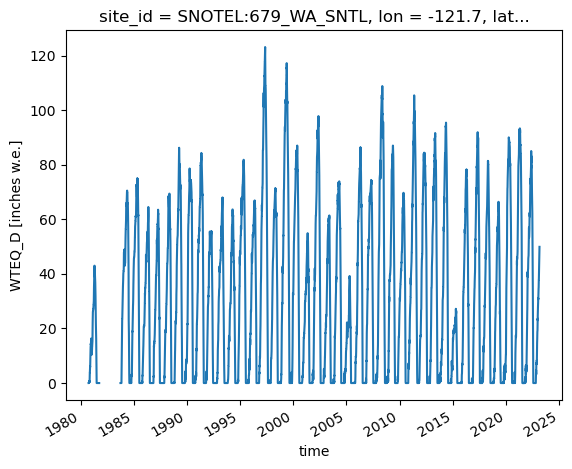

In [ ]:
ds.sel(site_id=sitecode)['WTEQ_D'].plot();

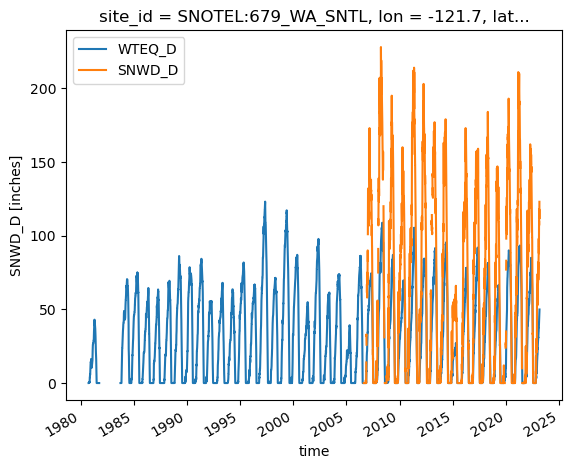

In [ ]:
f, ax = plt.subplots()
ds.sel(site_id=sitecode)['WTEQ_D'].plot(ax=ax, label='WTEQ_D')
ds.sel(site_id=sitecode)['SNWD_D'].plot(ax=ax, label='SNWD_D')
ax.legend();

In [ ]:
ds.sel(site_id=sitecode_list)['SNWD_D']

<xarray.DataArray 'SNWD_D' (time: 16219, site_id: 2)>
array([[ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       ...,
       [ nan, 127.],
       [ nan,  nan],
       [ nan,  nan]])
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:679_WA_SNTL' 'SNOTEL:998_WA_SNTL'
    lon      (site_id) float64 -121.7 -121.4
    lat      (site_id) float64 46.78 48.86
    elev     (site_id) float64 1.564e+03 1.606e+03
Attributes:
    description:  SNOTEL snow depth measurements (SNWD_D)
    units:        inches

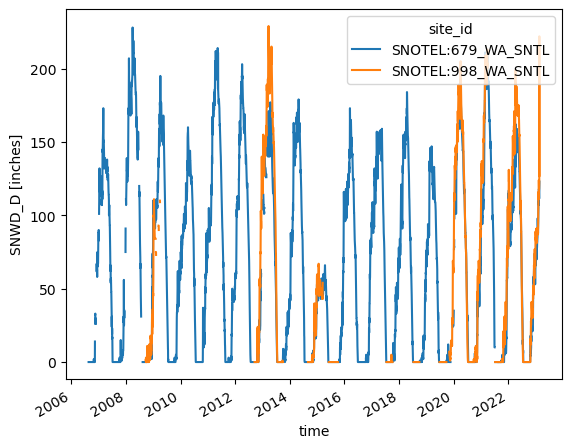

In [ ]:
ds.sel(site_id=sitecode_list)['SNWD_D'].plot.line(x="time");

In [ ]:
#Remember we used hvplot for pandas
#import hvplot.pandas

In [ ]:
import hvplot.xarray

In [ ]:
#ds.sel(site_id=sitecode).hvplot()

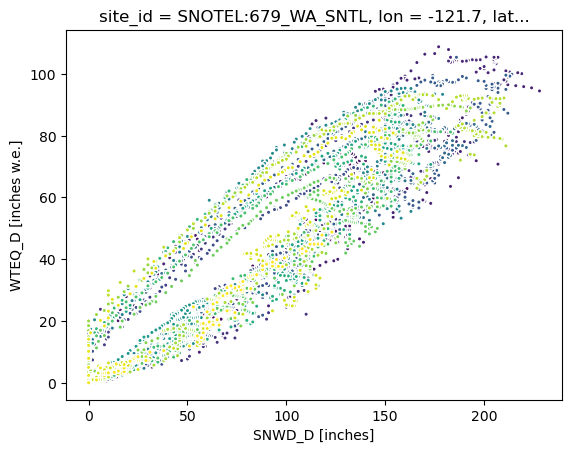

In [ ]:
ds.sel(site_id=sitecode).plot.scatter(x="SNWD_D", y="WTEQ_D", s=10, c=ds.isel(site_id=0)['time']);

In [ ]:
#ds.hvplot(kind='scatter', x='lon', y='lat', c='elev', aspect='equal')

### Interactive plot with time slider

In [ ]:
#ds.hvplot(kind='scatter', x='lon', y='lat', c='SNWD_D', aspect='equal', clim=(0,150), cmap='inferno')

## Add projected coordinates

In [ ]:
from pyproj import CRS, Transformer

In [ ]:
crs_4326 = CRS.from_epsg(4326)

In [ ]:
#Use our equal area projection from previous labs
crs_aea = CRS.from_proj4('+proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 +lon_0=-114.27')

In [ ]:
transformer = Transformer.from_crs(crs_4326, crs_aea)

In [ ]:
transformer

<Concatenated Operation Transformer: pipeline>
Description: axis order change (2D) + unknown
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)

In [ ]:
x, y = transformer.transform(ds['lat'], ds['lon'])

In [ ]:
x[0:10], y[0:10]

(array([-641830.34227843,  783444.60403791, -219670.85812494,
         260151.57870442,  256411.14413521, -545201.83052402,
        -563757.73421726, -609610.91738397,  225520.62714738,
         702809.29230722]),
 array([ 126514.02974903, -447629.27923716, -179747.45522562,
         552612.93311311,  553958.49455869,   92343.21913656,
         784714.06105929,  492131.94845037,  -19505.12211235,
        -211932.9662484 ]))

### Assign as new alternative coordinates (preserving original dimensions)
* https://docs.xarray.dev/en/stable/generated/xarray.Dataset.assign_coords.html

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (time: 16219, site_id: 806)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:1000_OR_SNTL' ... 'SNOTEL:999_WA_SNTL'
    lon      (site_id) float64 -122.2 -105.4 -116.9 ... -110.8 -121.4 -121.7
    lat      (site_id) float64 42.87 37.61 40.36 46.91 ... 40.89 48.86 48.76
    elev     (site_id) float64 1.832e+03 3.246e+03 ... 1.606e+03 1.073e+03
Data variables:
    SNWD_D   (time, site_id) float64 nan nan nan nan nan ... nan nan nan nan nan
    WTEQ_D   (time, site_id) float64 nan nan nan nan nan ... nan nan 61.9 39.1

In [ ]:
ds = ds.assign_coords(x=('site_id', x), y=('site_id', y))

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (time: 16219, site_id: 806)
Coordinates:
  * time     (time) datetime64[ns] 1978-10-01 1978-10-02 ... 2023-02-25
  * site_id  (site_id) object 'SNOTEL:1000_OR_SNTL' ... 'SNOTEL:999_WA_SNTL'
    lon      (site_id) float64 -122.2 -105.4 -116.9 ... -110.8 -121.4 -121.7
    lat      (site_id) float64 42.87 37.61 40.36 46.91 ... 40.89 48.86 48.76
    elev     (site_id) float64 1.832e+03 3.246e+03 ... 1.606e+03 1.073e+03
    x        (site_id) float64 -6.418e+05 7.834e+05 ... -5.274e+05 -5.474e+05
    y        (site_id) float64 1.265e+05 -4.476e+05 ... 7.854e+05 7.764e+05
Data variables:
    SNWD_D   (time, site_id) float64 nan nan nan nan nan ... nan nan nan nan nan
    WTEQ_D   (time, site_id) float64 nan nan nan nan nan ... nan nan 61.9 39.1

In [ ]:
#ds.hvplot(kind='scatter', x='x', y='y', c='SNWD_D', aspect='equal', cmap='inferno', s=5, clim=(0,150))